### Simple model to predict a successful protest

create a model which predict if a protest was a successful protest or failed protest

gets 'size greater than 3% of pop' and 'violent / non violent' for each protest as its input, and predicts if it was a successful protest or a failed one.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pylab import rcParams
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#### Datasets

In [2]:
# 'NAVCO'
data_path = "datasets/NAVCO.xls"
data = pd.read_excel(data_path)

# 'World Population 1960-2018'
world_pop_path = "datasets/population.csv"
world_pop = pd.read_csv(world_pop_path)

In [3]:
world_pop = world_pop.rename(columns={'Year': 'year', 'Country Name': 'location'}) # rename columns for easier merge
# create 'prot' to keep original dataframe
data = pd.merge(data, world_pop) # merge the two datasets to get population per country for each year

In [4]:
data.head()

,camp_name,id,year,campyearid,location,target,loc_iso,loc_cow,loc_vdem,territory,...,coding_notes,ra_initials,tccode,lccode,start_date_obsolete,end_date_obsolete,success,progress,outcomes_refs,Count
0,Active Forces,1,1991,1_1991,Madagascar,Didier Radsiraka,450.0,580.0,125.0,NaN,...,http://www.iss.org.za/pubs/papers/89/Paper89.h...,NaN,580.0,580.0,5/1/1991,2/10/1993,0,3,Gow 1997,11942819
1,Active Forces,1,1992,1_1992,Madagascar,Didier Radsiraka,450.0,580.0,125.0,NaN,...,Reuters lba0000020011123dobp03sm6 ; ;,NaN,580.0,580.0,5/1/1991,2/10/1993,0,3,Gow 1997,12301336
2,Active Forces,1,1993,1_1993,Madagascar,Didier Radsiraka,450.0,580.0,125.0,NaN,...,Reuters lba0000020011120dp6o06zif ; ;,NaN,580.0,580.0,5/1/1991,2/10/1993,1,4,NaN,12675460
3,Afar insurgency,2,1991,2_1991,Djibouti,Djibouti regime,262.0,522.0,113.0,NaN,...,; UCDP provides extensive coverage of the cam...,NaN,522.0,522.0,11/12/1991,26/12/1994,0,1,FRUD was able to take over large areas of the ...,606844
4,Afar insurgency,2,1992,2_1992,Djibouti,Djibouti regime,262.0,522.0,113.0,NaN,...,; UCDP provides extensive coverage of the cam...,NaN,522.0,522.0,11/12/1991,26/12/1994,0,2,"DJIBOUTI Human Rights Practices, 1992: Departm...",615054


#### filtering dataset
create dataframe in which each protest has following features:
- `violence` - was the protest violent or non violent
- `success` - was the protests a success or a failure
- `above_3%` - participants were greater or less than 3% of population

In [5]:
# filtering df
camp = data.copy() # *call it 'data2' to keep original dataframe
camp = camp[camp.reliability != 1] # delete non reliable rows

In [6]:
# most participants for each protest 
part = camp.sort_values(by=['total_part'],ascending=False)
part = part[part.total_part >= 0]
part = part.drop_duplicates(subset=['camp_name'], keep='first')
part = part.loc[:,['camp_name','total_part','Count','prim_meth']]

# filter each campaigns multiple rows to find if one of them was successful
success = camp.sort_values(by=['success'],ascending=False)
success = success[success.success >= 0]
success = success.drop_duplicates(subset=['camp_name'], keep='first')
success = success.loc[:,['camp_name','success']]

# sorts protests by year and keeps only 'name','year' features
camp = camp.sort_values(by=['year'],ascending=True)
camp = camp.drop_duplicates(subset=['camp_name'], keep='first')
camp = camp.loc[:,['camp_name','year']]

# merge dataframes to get final dataset
camp = pd.merge(camp, part)
camp = pd.merge(camp, success)

# 0=>1 & 1=>0, to create bool 'violence' feature
camp['prim_meth'] = camp['prim_meth'].map({0 : True, # prim_meth==0 => violent
                                           1 : False}) # prim_meth==1 => non violent
# bool success
camp['success'] = camp['success'].map({0 : False, # 0 => False
                                       1 : True}) # 1 => True

camp = camp.rename(columns={"prim_meth": "violence","total_part":"participants","Count":"total_pop"}) # rename

In [7]:
camp.iloc[:3]

,camp_name,year,participants,total_pop,violence,success
0,SWAPO,1960,9999,971121,True,True
1,Cameroon anti-Ahidjo government movement,1960,3000,5176918,True,False
2,Khmer Rouge,1960,205001,7449238,True,True


#### Add `above_3%` bool feature

In [8]:
# calculate perc_of_total feature
perc_of_total = []
perc = 0
# (part/total)*100
for x in range(len(camp)): 
    perc = (camp.participants.iloc[x] / camp.total_pop.iloc[x])*100
    perc_of_total.append(perc) # adding each value to its camp_name index

camp['perc_of_total'] = perc_of_total # adding new feature

camp['above_3%'] = np.where(camp['perc_of_total'] >= 3, # create new feature based on: perc_of_total >= 3
                            True, # greater than 3%
                            False) # less than 3%
camp['perc_of_total'] = camp['perc_of_total'].apply(lambda x: float("{0:.5f}".format(x))) # value becomes float .5

In [9]:
camp[:10] # 10 protests

,camp_name,year,participants,total_pop,violence,success,perc_of_total,above_3%
0,SWAPO,1960,9999,971121,True,True,1.02963,False
1,Cameroon anti-Ahidjo government movement,1960,3000,5176918,True,False,0.05795,False
2,Khmer Rouge,1960,205001,7449238,True,True,2.75197,False
3,Algerian Revolt/ National Liberation Front,1960,37600,11057863,True,True,0.34003,False
4,Zambia Anti-occupation,1960,1000000,3360104,False,True,29.76098,True
5,South Africa First Defiance Campaign,1960,70000,17099840,False,False,0.40936,False
6,Naga Rebellion,1960,4500,945601831,True,False,0.00048,False
7,Indonesian leftists / Anti Sukarno,1960,10000,87751068,True,False,0.01140,False
8,Malayan Emergency,1960,350,8156347,True,False,0.00429,False
9,Darul Islam,1960,4000,87751068,True,False,0.00456,False


#### Create a model which predicts successful protests based on their use of violence and % of total population

Using logistic regression, create a model which will get `success` as a label and 2 independent variables:
- `above 3%` - protest size above 3% of population = 1, else = 0
- `violence` - violent protest = 1, non violent protest = 0 

to see if model can predict a successful protest based on those 2 variables.


**X** = violence & above 3% features.  
**y** = the success labels.

In [10]:
# train
X = camp.loc[:,['violence','above_3%']] # independent variables
y = camp['success'] # labels, what is it going to predict

In [11]:
# training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4,random_state=100)

logmodel=LogisticRegression()

logmodel.fit(X_train,y_train) # train the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Predictions
Show results in a **conffusion matrix**

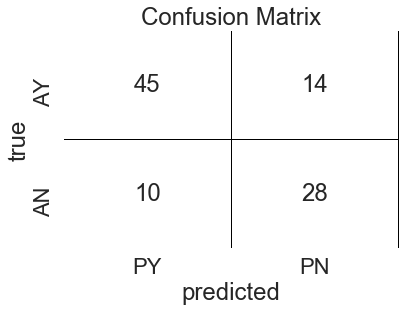

In [13]:
flatui = ["white"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex()) # custom color map for heatmap, contains: 'white'

# predictions
predictions = logmodel.predict(X_test) # predict

cm = confusion_matrix(y_test,predictions) # craetes confusion matrix

# show confusion matrix heapmap, just for visualization
sns.heatmap(cm, annot=True, # show ammount
            cmap=my_cmap, # colormap = custom
            cbar=False, # no colorbar
            linewidths=0.1, # lines between squares
            linecolor='black', # black lines
            label='big') # bigger font

plt.xlabel('predicted')
plt.ylabel('true')
sns.set(font_scale=2)
plt.yticks([0.5,1.5],['AY','AN'])
plt.xticks([0.5,1.5],['PY','PN'])
plt.title('Confusion Matrix')
plt.show()

the model successfuly predicted alot of successful protests(45/59), and most of the failed protests(28/38)  

---

$$ Precision = \frac{TP}{TP+FP} = \frac{45}{45+10}  = 81\% $$

$$ Recall = \frac{TP}{TP+FN} = \frac{45}{45+14}  = 76\% $$

Precision is higher, the main reason is to find successful protests

---

#### Check model accuracy score to see its performance

In [14]:
accuracy_score(y_test,predictions)

0.7525773195876289

$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} = \frac{45+28}{45+28+10+14}  = 75\% $$

---

#### Check protests probability
5 protests from the X test and their probability predicted by the model:

In [15]:
X_test.iloc[:5]

,violence,above_3%
111,False,True
150,True,False
188,True,False
134,False,False
202,False,False


In [16]:
logmodel.predict_proba(X_test)[:5]

array([[0.33366217, 0.66633783],
       [0.71130207, 0.28869793],
       [0.71130207, 0.28869793],
       [0.49539749, 0.50460251],
       [0.49539749, 0.50460251]])

Left column is fail predictions, right column is success predicitons

---

Although the exact result for the question what makes a successful protest will depend on many factors,  
this model was not bad at predicting successful & failed protests.